In [1]:
# machine learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm

# Visualization of data
import matplotlib.pyplot as plt

import random as rand
import os
import mne
import math
import scipy

import numpy as np

# Connects to the database
#import mysql.connector

In [2]:
def Add_Noise(s, SNR):
    # Compute d = s + n such that SNR = Ps/Pn
    #
    # s: Input signal
    # SNR: Desired signal-to-noise ratio
    # d: Output signal
    n = np.array(rand.sample(range(len(s)),k=len(s))).astype(float)
    Es = sum(np.square(s[:]))
    En = sum(np.square(n[:]))
    alpha = float(math.sqrt(Es/(SNR*En)))
    d = s+alpha*n
    return d,alpha*(n.astype(float))


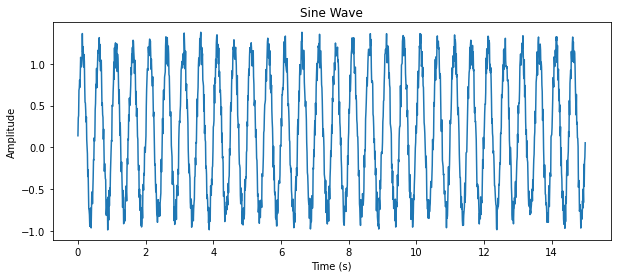

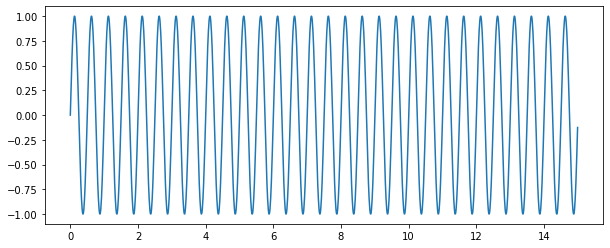

In [3]:
amplitude = 1
frequency = 2
phase = 0
sampling_rate = 100

time = np.arange(0,15, 1/sampling_rate) # 0.001 sec
y = amplitude * np.sin(2 * np.pi * frequency * time + phase)

noise_y,other = Add_Noise(y,10)
plt.figure(figsize=(10,4))
plt.plot(time,noise_y)
plt.title("Sine Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()
plt.figure(figsize=(10,4))
plt.plot(time, y)
plt.show()


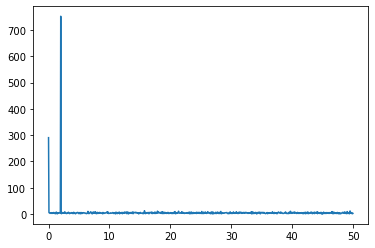

In [12]:
from scipy.fft import fft, fftfreq

z = fft(noise_y)
#b = math.sqrt(z*np.conj(z))
size = len(noise_y)
a = abs(z) # magnitude
f = fftfreq(size, 1/sampling_rate)[:size//2]
plt.plot(f,a[0:size//2])
plt.show()

In [4]:
num_of_samples = 30000
# Containers for samples.
n_samples = []
c_samples = []
x_s = []
y_s = [] # array of y values

for j in range(0,num_of_samples):
    for i in range(0,len(y)):
        x_s.append(time[i])
        y_s.append(noise_y[i])
        
    # Append to noisy Samples
    n_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array 
    
    for k in range(0,len(y)):
        x_s.append(time[k])
        y_s.append(y[k])
        
    # Append to clean Samples
    c_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array
    


In [5]:
print("Going to next computations...\n")
n_samples = np.array(n_samples)
c_samples = np.array(c_samples)

x_val_noisy, y_val_noisy = n_samples[:,0], n_samples[:,1]
x_val_pure, y_val_pure = c_samples[:,0], c_samples[:,1]

# Reshape Data and utilize Binary Cross Entropy
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  


Going to next computations...



In [20]:
print(noisy_input.shape)

(12005, 1000, 1)


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
# Model Configuration
input_shape = (1500,1)
batch_size = 120
no_epochs = 30
train_test_split = 0.3
validation_split = 0.3
verbosity = 1
max_norm_value = 2.0

# Create the model
model = Sequential()
model.add(Conv1D(256, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(Conv1D(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(16, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(32, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(64, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1DTranspose(256, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv1D(1, kernel_size=3, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same'))

print(model.summary())
'''
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input))
noisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]
pure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]

callback = EarlyStopping(monitor='val_loss', patience = 2)

# Compile and fit data
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                callbacks = [callback],
                validation_split=validation_split)
'''

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1498, 256)         1024      
                                                                 
 conv1d_6 (Conv1D)           (None, 1496, 64)          49216     
                                                                 
 conv1d_7 (Conv1D)           (None, 1494, 32)          6176      
                                                                 
 conv1d_8 (Conv1D)           (None, 1492, 16)          1552      
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 1494, 16)         784       
 ranspose)                                                       
                                                                 
 conv1d_transpose_5 (Conv1DT  (None, 1496, 32)         1568      
 ranspose)                                            

"\n# Train/test split\npercentage_training = math.floor((1 - train_test_split) * len(noisy_input))\nnoisy_input, noisy_input_test = noisy_input[:percentage_training], noisy_input[percentage_training:]\npure_input, pure_input_test = pure_input[:percentage_training], pure_input[percentage_training:]\n\ncallback = EarlyStopping(monitor='val_loss', patience = 2)\n\n# Compile and fit data\nmodel.compile(optimizer='adam', loss='binary_crossentropy')\nhistory = model.fit(noisy_input, pure_input,\n                epochs=no_epochs,\n                batch_size=batch_size,\n                callbacks = [callback],\n                validation_split=validation_split)\n"

dict_keys(['loss', 'val_loss'])


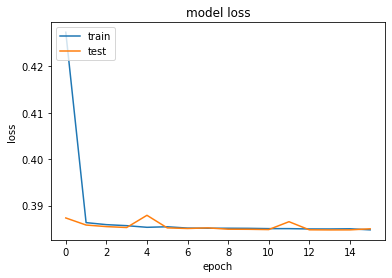

In [7]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


(1, 1000, 1)
1/1 [==============================] - 1s 575ms/step


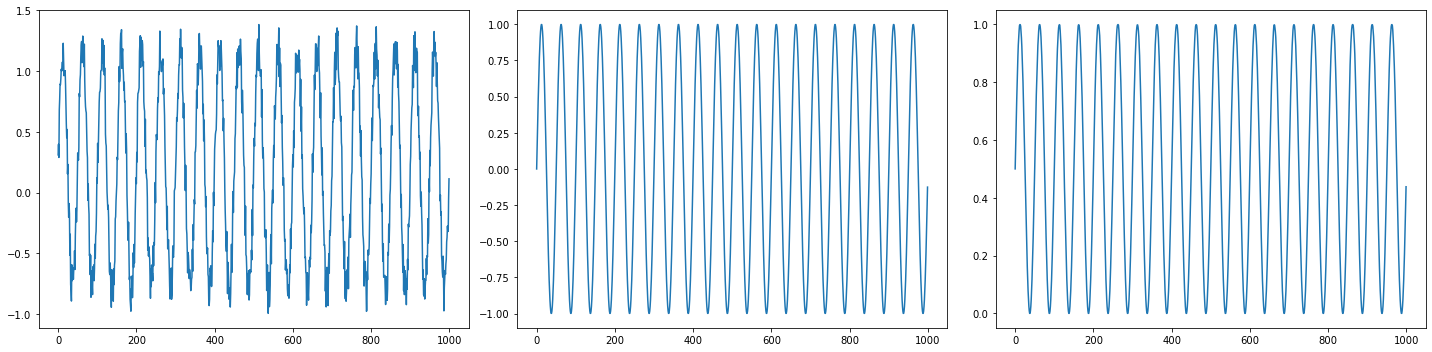

In [40]:
# Generate reconstructions
num_reconstructions = 1
samples = noisy_input_test[:num_reconstructions]
print(samples.shape)
reconstructions = model.predict(samples)


# Plot reconstructions
for i in np.arange(0, num_reconstructions):
    # Prediction index
    prediction_index = i + percentage_training
    # Get the sample and the reconstruction
    original = y_val_noisy[prediction_index]
    pure = y_val_pure[prediction_index]
    reconstruction = np.array(reconstructions[i])
    # Matplotlib preparations
    fig, axes = plt.subplots(1, 3)
    # Plot sample and reconstruciton
    plt.rcParams["figure.figsize"] = (20,5)
    axes[0].plot(original)
    axes[1].plot(pure)
    axes[2].plot(reconstruction)
    fig.tight_layout()
    plt.show()

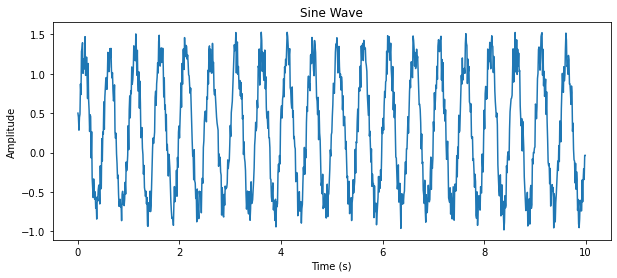

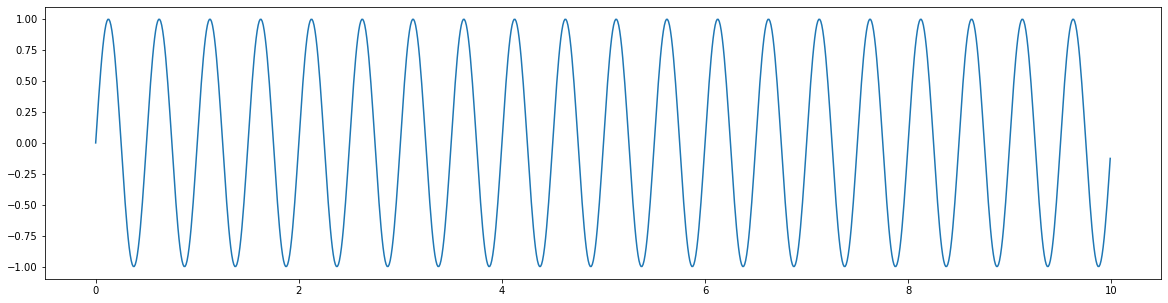

In [59]:
amplitude = 1
frequency = 2
phase = 0
sampling_rate = 100

time = np.arange(0,10, 1/sampling_rate) # 0.001 sec
y = amplitude * np.sin(2 * np.pi * frequency * time + phase)
noise_y,other = Add_Noise(y,5)
plt.figure(figsize=(10,4))
plt.plot(time,noise_y)
plt.title("Sine Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()
plt.plot(time, y)
plt.show()

In [61]:
num_of_samples = 50000
# Containers for samples.
n_samples = []
c_samples = []
x_s = []
y_s = [] # array of y values

for j in range(0,num_of_samples):
    for i in range(0,len(y)):
        x_s.append(time[i])
        y_s.append(noise_y[i])
        
    # Append to noisy Samples
    n_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array 
    
    for k in range(0,len(y)):
        x_s.append(time[k])
        y_s.append(y[k])
        
    # Append to clean Samples
    c_samples.append((x_s,y_s))
    
    x_s = [] # clear array
    y_s = [] # clear array
    


In [62]:
print("Going to next computations...\n")
n_samples = np.array(n_samples)
c_samples = np.array(c_samples)

x_val_noisy, y_val_noisy = n_samples[:,0], n_samples[:,1]
x_val_pure, y_val_pure = c_samples[:,0], c_samples[:,1]

# Reshape Data and utilize Binary Cross Entropy
np.seterr(invalid='ignore')
y_val_noisy_r = []
y_val_pure_r = []
for i in range(0, len(y_val_noisy)):
    noisy_sample = y_val_noisy[i]
    pure_sample = y_val_pure[i]
    noisy_sample = np.nan_to_num((noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample)))
    pure_sample = np.nan_to_num((pure_sample - np.min(pure_sample)) / (np.max(pure_sample) - np.min(pure_sample)))
    y_val_noisy_r.append(noisy_sample)
    y_val_pure_r.append(pure_sample)
    
y_val_noisy_r   = np.array(y_val_noisy_r)
y_val_pure_r    = np.array(y_val_pure_r)
noisy_input     = y_val_noisy_r.reshape((y_val_noisy_r.shape[0], y_val_noisy_r.shape[1], 1))
pure_input      = y_val_pure_r.reshape((y_val_pure_r.shape[0], y_val_pure_r.shape[1], 1))  


Going to next computations...



In [63]:
batch_size = 120
history = model.fit(noisy_input, pure_input,
                epochs=no_epochs,
                batch_size=batch_size,
                callbacks = [callback],
                validation_split=validation_split)

Epoch 1/30
292/292 [==============================] - 319s 1s/step - loss: 0.4532 - val_loss: 0.5060
Epoch 2/30
292/292 [==============================] - 364s 1s/step - loss: 0.3864 - val_loss: 0.5026
Epoch 3/30
292/292 [==============================] - 362s 1s/step - loss: 0.3860 - val_loss: 0.5016
Epoch 4/30
292/292 [==============================] - 348s 1s/step - loss: 0.3858 - val_loss: 0.4990
Epoch 5/30
292/292 [==============================] - 364s 1s/step - loss: 0.3856 - val_loss: 0.4994
Epoch 6/30
292/292 [==============================] - 375s 1s/step - loss: 0.3855 - val_loss: 0.4999


In [5]:
import mysql.connector
# Connecting to the Database
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
)

mycursor = mydb.cursor()

mycursor.execute("CREATE DATABASE IF NOT EXISTS Biomedical")

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="",
  database="Biomedical"
)

mycursor = mydb.cursor()

mycursor.execute("CREATE TABLE IF NOT EXISTS Signals (ynoise DOUBLE(31,30), yclean DOUBLE(31,30), yrec FLOAT(9,8))")

recarray = np.ravel(reconstruction).tolist()
for i in range(0,len(y_val_noisy[0])):
    sql = "INSERT INTO signals (ynoise, yclean,yrec) VALUES (%s, %s, %s)"
    valone = y_val_noisy[0][i]
    valtwo = y_val_pure[0][i]
    valthree = recarray[i]
    val = [(valone,valtwo,valthree)]
    mycursor.executemany(sql, val)
    mydb.commit()

'\nrecarray = np.ravel(reconstruction).tolist()\nfor i in range(0,len(y_val_noisy[0])):\n    sql = "INSERT INTO signals (ynoise, yclean,yrec) VALUES (%s, %s, %s)"\n    valone = y_val_noisy[0][i]\n    valtwo = y_val_pure[0][i]\n    valthree = recarray[i]\n    val = [(valone,valtwo,valthree)]\n    mycursor.executemany(sql, val)\n    mydb.commit()\n'